# Knowledge Graph – A Powerful Data Science Technique to Mine Information from Text 

https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/

## Sentence Segmentation

The first step in building a knowledge graph is to split the text document or article into sentences. Then, we will shortlist only those sentences in which there is exactly 1 subject and 1 object. Let’s look at a sample text below:

“Indian tennis player Sumit Nagal moved up six places from 135 to a career-best 129 in the latest men’s singles ranking. The 22-year-old recently won the ATP Challenger tournament. He made his Grand Slam debut against Federer in the 2019 US Open. Nagal won the first set.”

Let’s split the paragraph above into sentences:

1. Indian tennis player Sumit Nagal moved up six places from 135 to a career-best 129 in the latest men’s singles ranking
2. The 22-year-old recently won the ATP Challenger tournament
3. He made his Grand Slam debut against Federer in the 2019 US Open
4. Nagal won the first set

Out of these four sentences, we will shortlist the second and the fourth sentences because each of them contains 1 subject and 1 object. In the second sentence, “22-year-old” is the subject and the object is “ATP Challenger tournament”. In the fourth sentence, the subject is “Nagal” and “first set” is the object:

![alt text](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/10/entities.png)

The challenge is to make your machine understand the text, especially in the cases of multi-word objects and subjects. For example, extracting the objects in both the sentences above is a bit tricky. Can you think of any method to solve this problem?

## Entities Extraction
The extraction of a single word entity from a sentence is not a tough task. We can easily do this with the help of parts of speech (POS) tags. The nouns and the proper nouns would be our entities.

However, when an entity spans across multiple words, then POS tags alone are not sufficient. We need to parse the dependency tree of the sentence. You can read more about dependency parsing in the following article.

* Introduction to Information Extraction using Python and spaCy

Let’s get the dependency tags for one of the shortlisted sentences. I will use the popular spaCy library for this task:

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

doc = nlp("The 22-year-old recently won ATP Challenger tournament.")

for tok in doc:
  print(tok.text, "-->",tok.dep_,"-->", tok.pos_)

The --> det --> DET
22-year --> npadvmod --> NUM
- --> punct --> PUNCT
old --> nsubj --> ADJ
recently --> advmod --> ADV
won --> ROOT --> VERB
ATP --> compound --> PROPN
Challenger --> compound --> PROPN
tournament --> dobj --> NOUN
. --> punct --> PUNCT


The subject (nsubj) in this sentence as per the dependency parser is “old”. That is not the desired entity. We wanted to extract “22-year-old” instead.

The dependency tag of “22-year” is amod which means it is a modifier of “old”. Hence, we should define a rule to extract such entities.

The rule can be something like this — extract the subject/object along with its modifiers and also extract the punctuation marks between them.

But then look at the object (dobj) in the sentence. It is just “tournament” instead of “ATP Challenger tournament”. Here, we don’t have the modifiers but compound words.

Compound words are those words that collectively form a new term with a different meaning. Therefore, we can update the above rule to ⁠— extract the subject/object along with its modifiers, compound words and also extract the punctuation marks between them.

In short, we will use dependency parsing to extract entities.

## Extract Relations

Entity extraction is half the job done. To build a knowledge graph, we need edges to connect the nodes (entities) to one another. These edges are the relations between a pair of nodes.

Let’s go back to the example in the last section. We shortlisted a couple of sentences to build a knowledge graph:



![alt text](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/10/info_extract.png)

Can you guess the relation between the subject and the object in these two sentences?

Both sentences have the same relation – “won”. Let’s see how these relations can be extracted. We will again use dependency parsing:

In [ ]:
doc = nlp("Nagal won the first set.")

for tok in doc:
  print(tok.text, "-->",tok.dep_,"-->", tok.pos_)

Nagal --> nsubj --> PROPN
won --> ROOT --> VERB
the --> det --> DET
first --> amod --> ADJ
set --> dobj --> NOUN
. --> punct --> PUNCT


To extract the relation, we have to find the ROOT of the sentence (which is also the verb of the sentence). Hence, the relation extracted from this sentence would be “won”.

Finally, the knowledge graph from these two sentences will be like this:



![alt text](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/10/sample_KG.png)

# Build a Knowledge Graph from Text Data

Time to get our hands on some code! Let’s fire up our Jupyter Notebooks (or whatever IDE you prefer).

We will build a knowledge graph from scratch by using the text from a set of movies and films related to Wikipedia articles. I have already extracted around 4,300 sentences from over 500 Wikipedia articles. Each of these sentences contains exactly two entities – one subject and one object. You can download these sentences from here.

I suggest using Google Colab for this implementation to speed up the computation time.

 

In [ ]:
# Import Libraries
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [ ]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("/content/drive/My Drive/Colab Notebooks/QARIK_placement_project/learning_stage_and_references/input/wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [ ]:
candidate_sentences['sentence'].sample(5)

496                    the theme that year was a hundred years in the future.
1230                                 the experience which included two films.
617                                 the album was released on april 23, 2013.
1844    all color reversal film sold today is developed with the e-6 process.
3673       the film's gross is the 66th highest ever in north american ranks.
Name: sentence, dtype: object

Let’s check the subject and object of one of these sentences. Ideally, there should be one subject and one object in the sentence:

In [32]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "-->",tok.dep_,"-->", tok.pos_)

the --> det --> DET
drawdown --> amod --> NOUN
process --> nsubjpass --> NOUN
is --> auxpass --> AUX
governed --> ROOT --> VERB
by --> agent --> ADP
astm --> compound --> NOUN
standard --> amod --> NOUN
d823 --> pobj --> PROPN


In [33]:
doc = nlp("john took decision in NI assembly")

for tok in doc:
  print(tok.text, "-->",tok.dep_,"-->", tok.pos_)

john --> nsubj --> PROPN
took --> ROOT --> VERB
decision --> dobj --> NOUN
in --> prep --> ADP
NI --> compound --> PROPN
assembly --> pobj --> NOUN


Perfect! There is only one subject (‘process’) and only one object (‘standard’). You can check for other sentences in a similar manner.

# Entity Pairs Extraction

To build a knowledge graph, the most important things are the nodes and the edges between them.

These nodes are going to be the entities that are present in the Wikipedia sentences. Edges are the relationships connecting these entities to one another. We will extract these elements in an unsupervised manner, i.e., we will use the grammar of the sentences.

The main idea is to go through a sentence and extract the subject and the object as and when they are encountered. However, there are a few challenges ⁠— an entity can span across multiple words, eg., “red wine”, and the dependency parsers tag only the individual words as subjects or objects.

So, I have created a function below to extract the subject and the object (entities) from a sentence while also overcoming the challenges mentioned above. I have partitioned the code into multiple chunks for your convenience:

In [ ]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

Let me explain the code chunks in the function above:

* **Chunk 1**

I have defined a few empty variables in this chunk. prv_tok_dep and prv_tok_text will hold the dependency tag of the previous word in the sentence and that previous word itself, respectively. prefix and modifier will hold the text that is associated with the subject or the object.

* **Chunk 2**

Next, we will loop through the tokens in the sentence. We will first check if the token is a punctuation mark or not. If yes, then we will ignore it and move on to the next token. If the token is a part of a compound word (dependency tag = “compound”), we will keep it in the prefix variable. A compound word is a combination of multiple words linked to form a word with a new meaning (example – “Football Stadium”, “animal lover”).

As and when we come across a subject or an object in the sentence, we will add this prefix to it. We will do the same thing with the modifier words, such as “nice shirt”, “big house”, etc.

* **Chunk 3**

Here, if the token is the subject, then it will be captured as the first entity in the ent1 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will be reset.

* **Chunk 4**

Here, if the token is the object, then it will be captured as the second entity in the ent2 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will again be reset.

* **Chunk 5**

Once we have captured the subject and the object in the sentence, we will update the previous token and its dependency tag.

Let’s test this function on a sentence:

In [30]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [34]:
get_entities("john took decision in NI assembly")

['john', 'NI assembly']

Great, it seems to be working as planned. In the above sentence, ‘film’ is the subject and ‘200 patents’ is the object.

Now we can use this function to extract these entity pairs for all the sentences in our data:

In [ ]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:58<00:00, 73.65it/s]


The list entity_pairs contains all the subject-object pairs from the Wikipedia sentences. Let’s have a look at a few of them:

In [ ]:
entity_pairs[10:20]

[['we', 'tests'],
 ['m global', 'international sales rights'],
 ['robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['', 'military  arrest'],
 ['train', 'vuk'],
 ['telepath', 'gallio'],
 ['singer', 'men']]

As you can see, there are a few pronouns in these entity pairs such as ‘we’, ‘it’, ‘she’, etc. We’d like to have proper nouns or nouns instead. Perhaps we can further improve the get_entities( ) function to filter out pronouns. For the time being, let’s leave it as it is and move on to the relation extraction part.

# Relation / Predicate Extraction

This is going to be a very interesting aspect of this article. Our hypothesis is that the predicate is actually the main verb in a sentence.

For example, in the sentence – “Sixty Hollywood musicals were released in 1929”, the verb is “released in” and this is what we are going to use as the predicate for the triple generated from this sentence.

The function below is capable of capturing such predicates from the sentences. Here, I have used spaCy’s rule-based matching:

In [ ]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

The pattern defined in the function tries to find the ROOT word or the main verb in the sentence. Once the ROOT is identified, then the pattern checks whether it is followed by a preposition (‘prep’) or an agent word. If yes, then it is added to the ROOT word.
Let me show you a glimpse of this function:

In [ ]:
get_relation("John completed the task")

'completed'

In [35]:
get_relation("john took decision in NI assembly")

'took'

Similarly, let’s get the relations from all the Wikipedia sentences:

In [ ]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:57<00:00, 75.30it/s]


Let’s take a look at the most frequent relations or predicates that we have just extracted:

In [ ]:
pd.Series(relations).value_counts()[:50]

is               370
was              297
released on       87
include           73
were              71
are               71
released          40
's                38
composed by       35
have              31
has               31
became            31
become            29
released in       27
included          26
produced          22
called            22
considered        20
made              20
had               20
been              18
be                18
used              17
scheduled         17
directed by       16
stars             16
written by        15
wrote             14
set               14
hired             14
produced by       14
introduced in     13
received          13
went              13
wanted            12
began in          11
won               11
began             11
sold              10
gave              10
features          10
shot in            9
used in            9
reported           9
gives              9
known as           9
opened             9
directed     

It turns out that relations like “A is B” and “A was B” are the most common relations. However, there are quite a few relations that are more associated with the overall theme – “the ecosystem around movies”. Some of the examples are “composed by”, “released in”, “produced”, “written by” and a few more.

# Build a Knowledge Graph

We will finally create a knowledge graph from the extracted entities (subject-object pairs) and the predicates (relation between entities).

Let’s create a dataframe of entities and predicates:

In [ ]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

Next, we will use the networkx library to create a network from this dataframe. The nodes will represent the entities and the edges or connections between the nodes will represent the relations between the nodes.

It is going to be a directed graph. In other words, the relation between any connected node pair is not two-way, it is only from one node to another. For example, “John eats pasta”:

In [ ]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

Let’s plot the network:

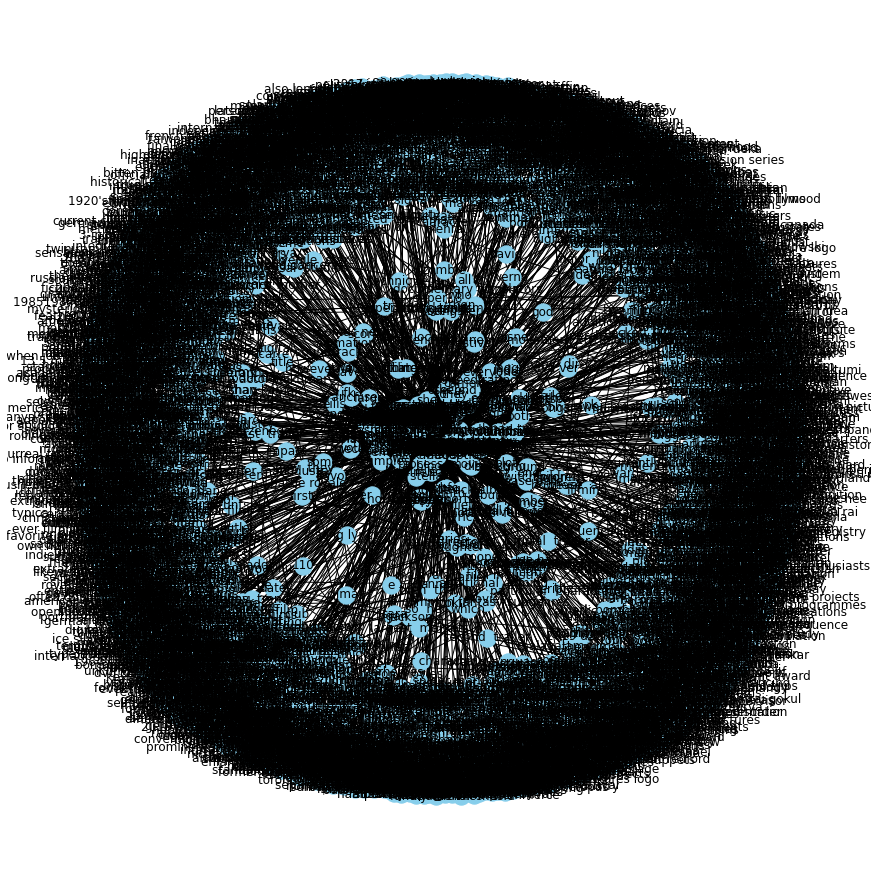

In [ ]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Well, this is not exactly what we were hoping for (still looks quite a sight though!).

It turns out that we have created a graph with all the relations that we had. It becomes really hard to visualize a graph with these many relations or predicates.

So, it’s advisable to use only a few important relations to visualize a graph. I will take one relation at a time. Let’s start with the relation “composed by”:

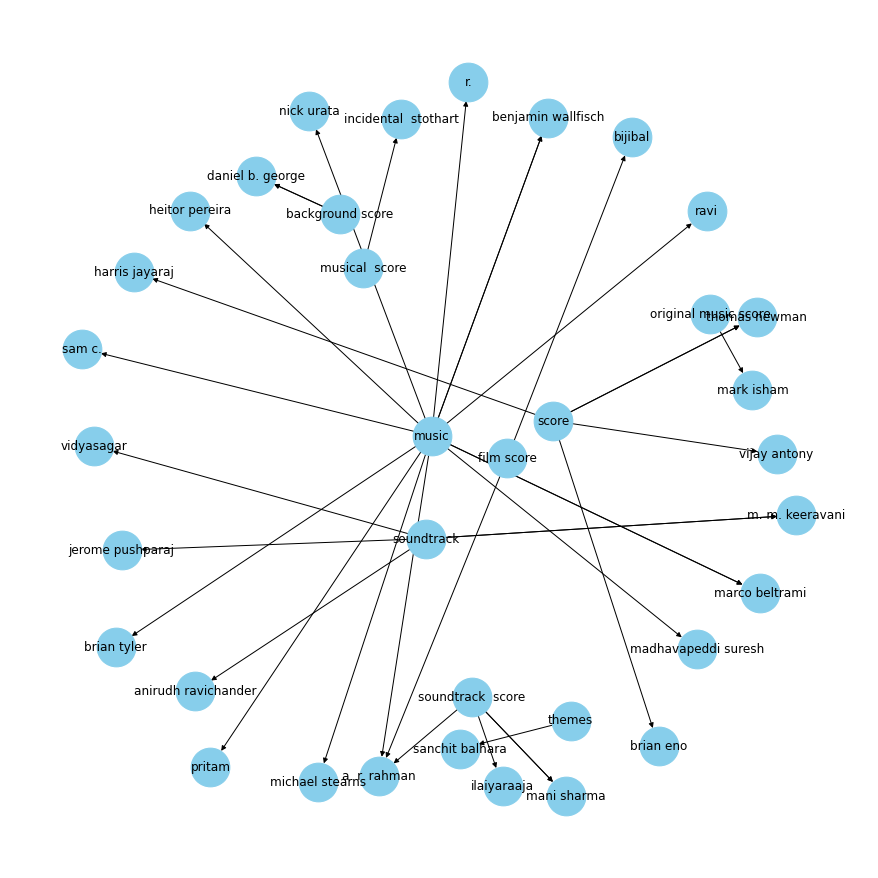

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

That’s a much cleaner graph. Here the arrows point towards the composers. For instance, A.R. Rahman, who is a renowned music composer, has entities like “soundtrack score”, “film score”, and “music” connected to him in the graph above.

Let’s check out a few more relations.

Since writing is an important role in any movie, I would like to visualize the graph for the “written by” relation:

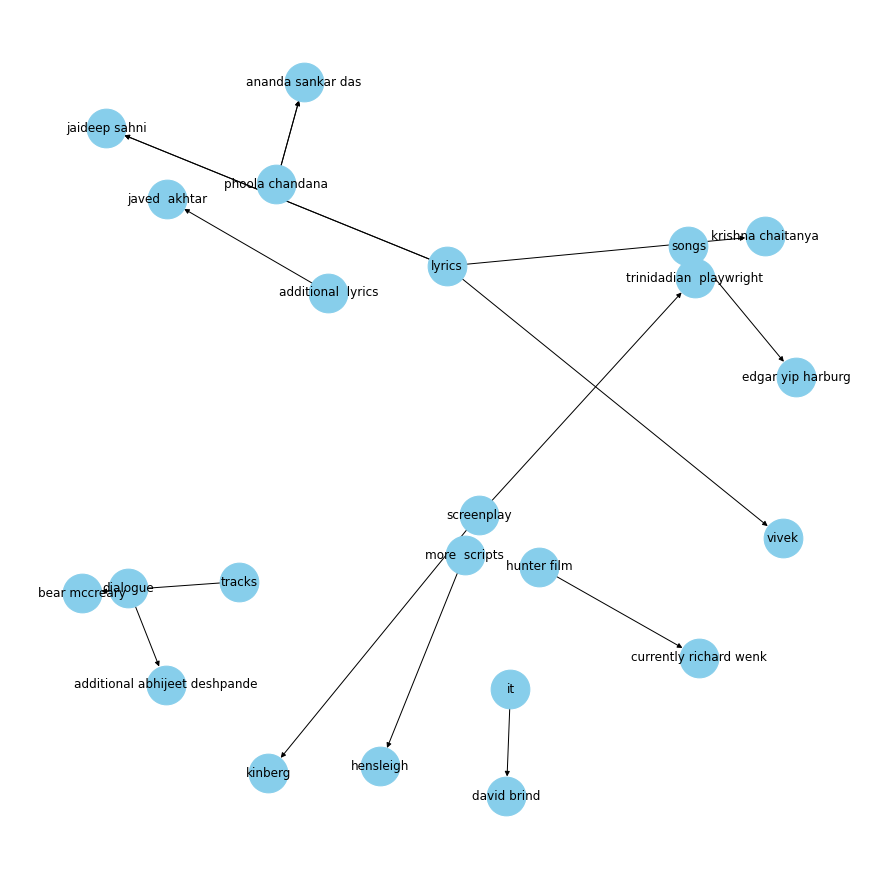

In [ ]:

G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Awesome! This knowledge graph is giving us some extraordinary information. Guys like Javed Akhtar, Krishna Chaitanya, and Jaideep Sahni are all famous lyricists and this graph beautifully captures this relationship.

Let’s see the knowledge graph of another important predicate, i.e., the “released in”:

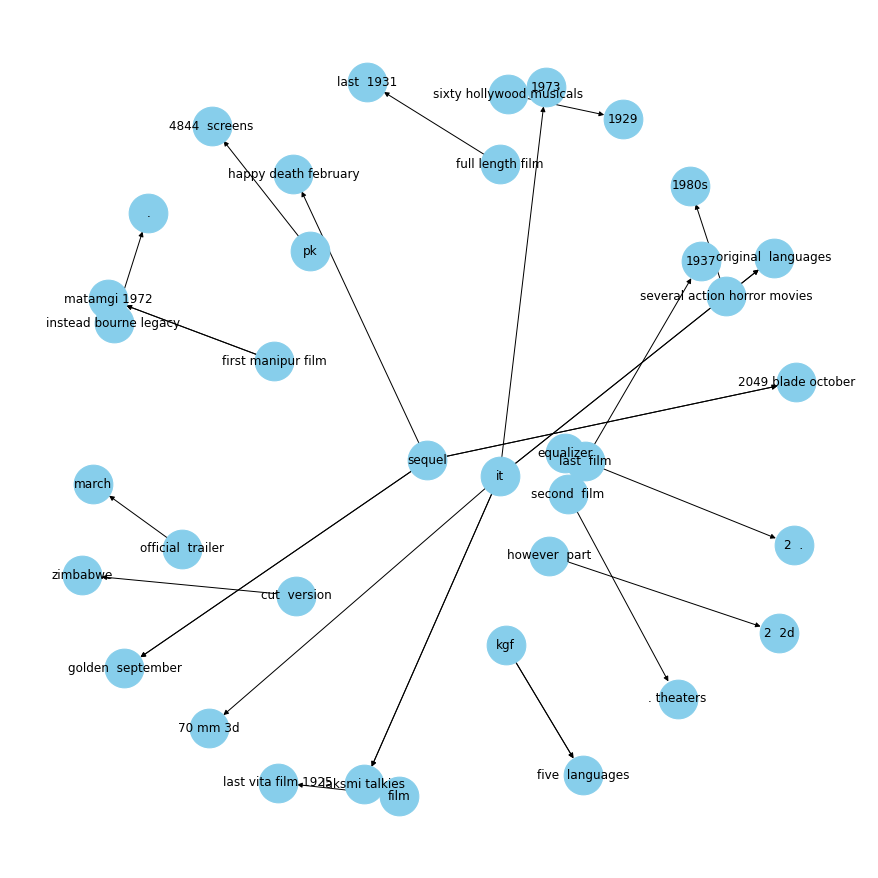

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

I can see quite a few interesting information in this graph. For example, look at this relationship – “several action horror movies released in the 1980s” and “pk released on 4844 screens”. These are facts and it shows us that we can mine such facts from just text. That’s quite amazing!

In this article, we learned how to extract information from a given text in the form of triples and build a knowledge graph from it.

However, we restricted ourselves to use sentences with exactly 2 entities. Even then we were able to build quite informative knowledge graphs. Imagine the potential we have here!

I encourage you to explore this field of information extraction more to learn extraction of more complex relationships. In case you have any doubt or you want to share your thoughts, please feel free to use the comments section below.

# FIN